## Find Closet Stable Pose using Brute Force Method
* This notebook provides an pipeline of how to find the closest stable pose $T_\text{part}^\text{tag}(x, y, z, \alpha, \beta, \gamma)$ to a given pose estimate $\widehat{T}_\text{part}^\text{tag}$. 
* Brute Force Method: Find the stable pose that is closest to the given estimate. The distance metric here is the **Augular Difference** between two orientation representaions.

### 1 Example with make-up Estimate for Mainshell
##### Step1: construct a list of stable poses(orientation) represented by Rotation matrices

In [135]:
from scipy.spatial.transform import Rotation
import numpy as np
import matplotlib.pyplot as plt

In [136]:
# these two lists should be element-aligned. 
# e.g. alphas[i] should correspond to z_offsets[i]
alphas_mainshell = np.radians([0, 180])
z_offsets_mainshell = np.array([0.0015, 0.0015])

def construct_R_sta_list(alphas):
    beta = 0
    # decretize gama at step of 1 degree
    gamas = np.radians(np.arange(0, 360, 1))
    stable_poses_R = []
    for alpha in alphas:
        for gama in gamas:
            R = Rotation.from_euler('xyz', [alpha, beta, gama])
            stable_poses_R.append(R.as_matrix())
    return stable_poses_R

stable_poses_R = construct_R_sta_list(alphas_mainshell)
len(stable_poses_R)

720

##### Step2: Find the closest three stable poses by iteratively computing the angular difference

In [137]:
R_est = Rotation.from_euler('xyz', np.radians([3, 5, 145])).as_matrix()

def angular_R_diff(R1, R2):
    R_diff = R1.T @ R2
    trace = np.trace(R_diff)
    angular_distance = np.rad2deg(np.arccos((trace - 1.) / 2.))
    return angular_distance

def find_top3_stable_poses(stable_poses_R, R_est, isPrint = True):
    angular_diffs = []
    for R_sp in stable_poses_R:
        angular_diffs.append(angular_R_diff(R_sp, R_est))

    # Get indices of the top three smallest angular differences
    top3_indices = np.argsort(angular_diffs)[:3]
    # Extract the corresponding rotation matrices
    top3_stable_poses_diff = [angular_diffs[i] for i in top3_indices]
    top3_stable_poses_R = [stable_poses_R[i] for i in top3_indices]

    if(isPrint):
        # Print the top three stable poses and their angular differences
        print("Estimate's euler angles:", Rotation.from_matrix(R_est).as_euler('xyz', degrees=True))
        print()
        for i, (matrix, diff) in enumerate(zip(top3_stable_poses_R, top3_stable_poses_diff)):
            euler_angles = Rotation.from_matrix(matrix).as_euler('xyz', degrees=True)
            print(f"Top {i + 1} Stable Pose:")
            print("Rotation Matrix:")
            print(matrix)
            print(f"Angular Difference: {diff:.2f} degrees")
            print("Euler Angles (degrees):", euler_angles)
            print()

    return top3_stable_poses_R

top3_stable_poses_R = find_top3_stable_poses(stable_poses_R, R_est)

Estimate's euler angles: [  3.   5. 145.]

Top 1 Stable Pose:
Rotation Matrix:
[[-0.81915204 -0.57357644  0.        ]
 [ 0.57357644 -0.81915204  0.        ]
 [ 0.          0.          1.        ]]
Angular Difference: 5.83 degrees
Euler Angles (degrees): [  0.   0. 145.]

Top 2 Stable Pose:
Rotation Matrix:
[[-0.80901699 -0.58778525  0.        ]
 [ 0.58778525 -0.80901699  0.        ]
 [ 0.          0.          1.        ]]
Angular Difference: 5.89 degrees
Euler Angles (degrees): [  0.   0. 144.]

Top 3 Stable Pose:
Rotation Matrix:
[[-0.82903757 -0.5591929   0.        ]
 [ 0.5591929  -0.82903757  0.        ]
 [ 0.          0.          1.        ]]
Angular Difference: 5.94 degrees
Euler Angles (degrees): [  0.   0. 146.]



In [138]:
def construct_T(R, t):
    T = np.eye(4)
    T[:3, :3] = R
    T[:3, 3] = t
    return T

R_sta = top3_stable_poses_R[0]
R_est = R_est
t = np.array([0, 0, 0])

# Construct transformation matrices
T_sta = construct_T(R_sta, t)

T_est = construct_T(R_est, t)

print("Transformation Matrix for Stable Pose:")
print(T_sta)

print("\nTransformation Matrix for Estimated Pose:")
print(T_est)

Transformation Matrix for Stable Pose:
[[-0.81915204 -0.57357644  0.          0.        ]
 [ 0.57357644 -0.81915204  0.          0.        ]
 [ 0.          0.          1.          0.        ]
 [ 0.          0.          0.          1.        ]]

Transformation Matrix for Estimated Pose:
[[-0.81603492 -0.57652683 -0.04127729  0.        ]
 [ 0.5713938  -0.81541313  0.09279308  0.        ]
 [-0.08715574  0.0521368   0.99482945  0.        ]
 [ 0.          0.          0.          1.        ]]


##### Step3: Create helper functions to draw results.

In [139]:
def draw_frame(ax, R, t, s=1., linewidth=1., linestyle='-'):
    t = np.reshape(t, -1)
    R = np.reshape(R, (3,3))
    o = t + R @ np.array([0., 0., 0.])
    x = t + R @ np.array([s, 0., 0.])
    y = t + R @ np.array([0., s, 0.])
    z = t + R @ np.array([0., 0., s])
    ax.plot(o[0], o[1], o[2], 'k.')
    ax.plot([o[0], x[0]], [o[1], x[1]], [o[2], x[2]], 'r', linewidth=linewidth, linestyle=linestyle)
    ax.plot([o[0], y[0]], [o[1], y[1]], [o[2], y[2]], 'g', linewidth=linewidth, linestyle=linestyle)
    ax.plot([o[0], z[0]], [o[1], z[1]], [o[2], z[2]], 'b', linewidth=linewidth, linestyle=linestyle)

def draw_view(ax, elev, azim, roll, T_sta, T_est, s=1.):
    ax.set_proj_type('ortho')
    
    # Pose estimate
    draw_frame(
        ax,
        T_est[:3, :3],
        T_est[:3, 3],
        s=s,
    )
    
    # Stable pose that is closest to pose estimate
    draw_frame(
        ax,
        T_sta[:3, :3],
        T_sta[:3, 3],
        s=s,
        linewidth=3.,
        linestyle='--',
    )
    
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    ax.set_zlim(0, 2)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.set_xticks([-1, 0, 1])
    ax.set_yticks([-1, 0, 1])
    ax.set_zticks([0, 1, 2])
    
    ax.set_aspect('equal')
    ax.view_init(elev=elev, azim=azim, roll=roll)

def draw_results(T_sta, T_est, s=1.):
    fig, (ax, ax_x, ax_y, ax_z) = plt.subplots(1, 4, figsize=(20, 60), subplot_kw={'projection': '3d'})
    draw_view(ax, 15., 30., 0., T_sta, T_est, s=s)
    draw_view(ax_x, 0., -90., 0., T_sta, T_est, s=s)
    draw_view(ax_y, 0., 0., 0., T_sta, T_est, s=s)
    draw_view(ax_z, 90., -90., 0., T_sta, T_est, s=s)
    fig.tight_layout()
    plt.show()

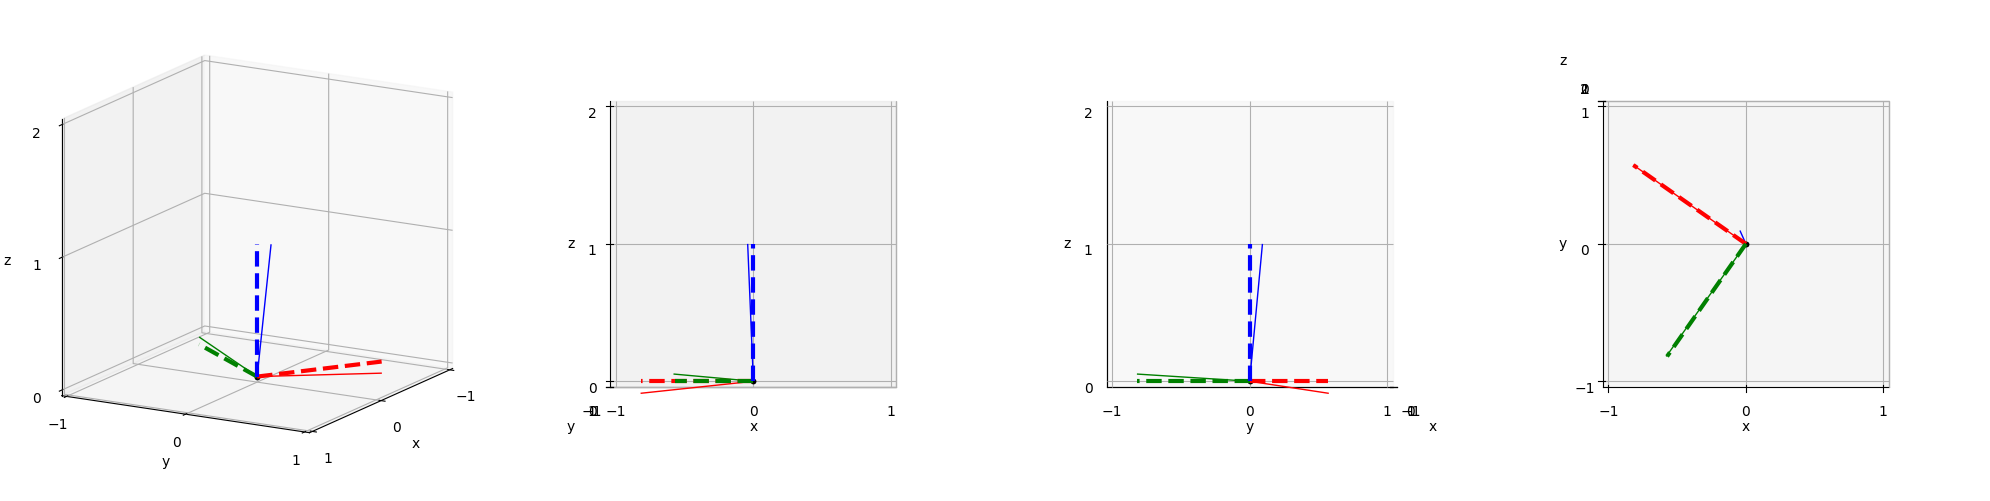

In [140]:
draw_results(T_sta, T_est)
# The solid line is for estimate
# The dashed line is for closest stable pose

### 2 Test pipeline with estimates from real experienment

#### 2.1 Insert Mold

In [141]:
# these two lists should be element-aligned. 
# e.g. alphas[i] should correspond to z_offsets[i]
alphas_insertmold = np.radians([0, 12, -146, 156])
z_offsets_insertmold = np.array([0.0021, 0.0019, 0.0032, 0.0013])

stable_poses_R = construct_R_sta_list(alphas_insertmold)
len(stable_poses_R)

1440

In [142]:
# TODO(yangfei): replace this with a real T_part_in_tag estimate
R_est = Rotation.from_euler('xyz', np.radians([5, 5, 105])).as_matrix()
T_est = np.eye(4)
T_est[:3, :3] = R_est
T_est[:3, 3] = np.array([0.1, 0.1, 0.005])

top3_stable_poses_R = find_top3_stable_poses(stable_poses_R, T_est[:3, :3], isPrint=False)

R_sta = top3_stable_poses_R[0]
alpha_sta = np.rad2deg(Rotation.from_matrix(R_sta).as_euler('xyz', degrees=True)[0])
index = np.where(alphas_insertmold == alpha_sta)[0]
z_offset_sta = z_offsets_insertmold[index]

# Construct transformation matrices
t_sta = np.array([T_est[0,3], T_est[1,3], z_offset_sta])
T_sta = construct_T(R_sta, t_sta)

print("Transformation Matrix for Stable Pose:")
print(T_sta)
print("\nTransformation Matrix for Estimated Pose:")
print(T_est)

Transformation Matrix for Stable Pose:
[[-0.25881905 -0.96592583  0.          0.1       ]
 [ 0.96592583 -0.25881905  0.          0.1       ]
 [ 0.          0.          1.          0.0021    ]
 [ 0.          0.          0.          1.        ]]

Transformation Matrix for Estimated Pose:
[[-0.25783416 -0.96421621  0.06171426  0.1       ]
 [ 0.96225019 -0.25049687  0.1064232   0.1       ]
 [-0.08715574  0.08682409  0.99240388  0.005     ]
 [ 0.          0.          0.          1.        ]]


/tmp/ipykernel_18715/2861446431.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  t_sta = np.array([T_est[0,3], T_est[1,3], z_offset_sta])


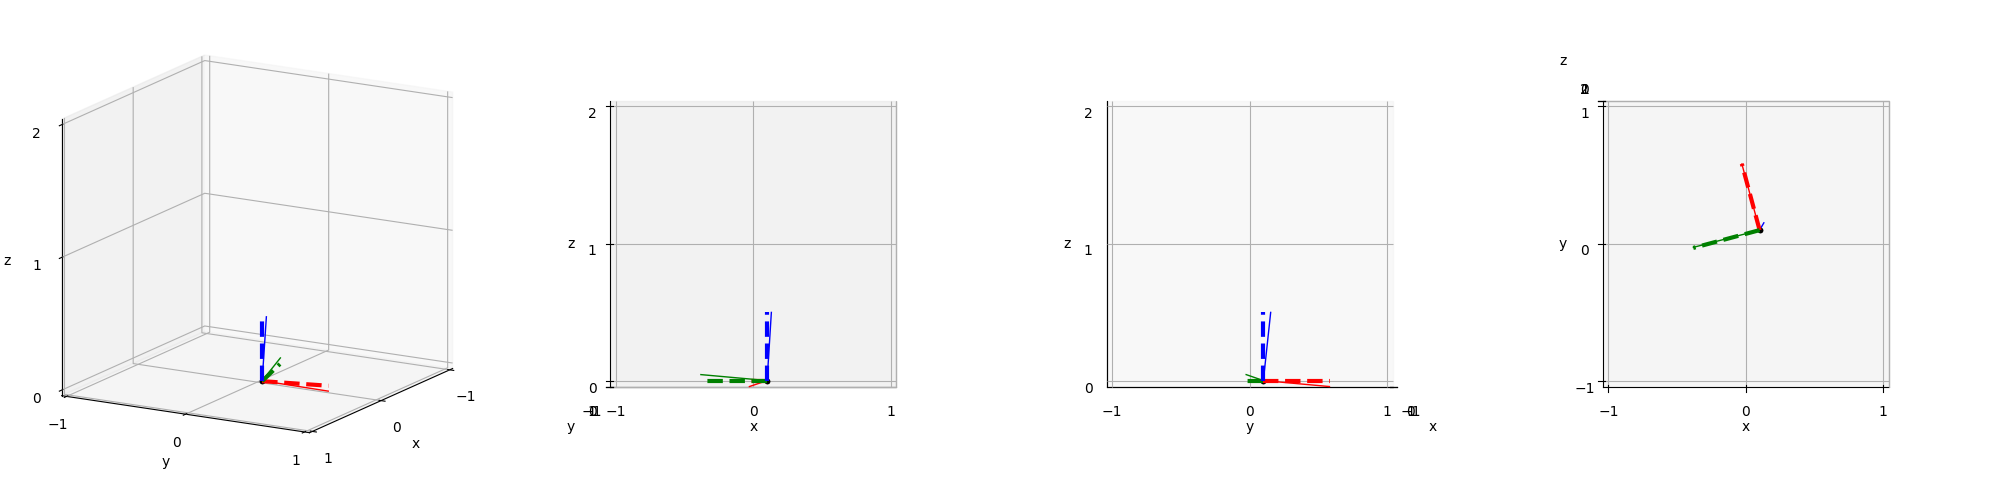

In [143]:
draw_results(T_sta, T_est, s=0.5)
# The solid line is for estimate
# The dashed line is for closest stable pose